# API Comparisons

---

## Summary

This notebook looks at the gathered statistics from the three APIs (PySyncObj, TiKV and HashiCorp) and analyzes their performance.

---

## Set-Up
### Necessary Imports

In [90]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Settings

In [91]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

Pretty printing has been turned OFF


### Globals

In [92]:
PATH = "../experiments/results_csv"
CSVS = {"HashiCorp": "hashicorp.2024-04-23T20-08.csv",
        "HashiCorp-Skeleton": "hashicorp.skeleton.2024-04-23T19-54.csv",
        "PySyncObj": "pysyncobj.2024-04-23T18-38.csv",
        "PySyncObj-Skeleton": "pysyncobj.skeleton.2024-04-23T17-57.csv", }

DATASETS = {csv: None for csv in CSVS}
for csv in CSVS:
    DATASETS[csv] = pd.read_csv(PATH + f"/{CSVS[csv]}")

FULL_DF = pd.concat(DATASETS.values())

In [93]:
FULL_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 9
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IMPLEMENTATION  40 non-null     object 
 1   RUN_IN_FILE     40 non-null     int64  
 2   MESSAGES_SENT   40 non-null     int64  
 3   COMMIT_TIME     40 non-null     float64
 4   CPU_UTIL        40 non-null     float64
 5   MAX_MEM         40 non-null     float64
 6   LOG_SIZE        40 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.5+ KB


### Functions

In [94]:
# At the 0.95 level for 10 datapoints
def conf_int(arr: pd.Series) -> tuple[float, float, float]:
    z = 2.92
    s = arr.std()
    m = arr.mean()
    n = len(arr)
    return m, (z * (s / math.sqrt(n)))

---

## Initial Exploration

In [95]:
# Remove skeletons
REAL_DF = FULL_DF[~FULL_DF['IMPLEMENTATION'].str.contains('skeleton')]
REAL_DF['IMPLEMENTATION'].unique()

array(['hashicorp', 'pysyncobj'], dtype=object)

In [96]:
# Skeletons only
SKEL_DF = FULL_DF[FULL_DF['IMPLEMENTATION'].str.contains('skeleton')]
SKEL_DF['IMPLEMENTATION'].unique()

array(['hashicorp.skeleton', 'pysyncobj.skeleton'], dtype=object)

In [97]:
REAL_DF.groupby(['IMPLEMENTATION']).describe()

RUN_IN_FILE                                            \
                     count mean      std  min   25%  50%   75%   max   
IMPLEMENTATION                                                         
hashicorp             10.0  5.5  3.02765  1.0  3.25  5.5  7.75  10.0   
pysyncobj             10.0  5.5  3.02765  1.0  3.25  5.5  7.75  10.0   

               MESSAGES_SENT                                               \
                       count    mean  std     min     25%     50%     75%   
IMPLEMENTATION                                                              
hashicorp               10.0  2000.0  0.0  2000.0  2000.0  2000.0  2000.0   
pysyncobj               10.0  2000.0  0.0  2000.0  2000.0  2000.0  2000.0   

                       COMMIT_TIME                                    \
                   max       count      mean           std       min   
IMPLEMENTATION                                                         
hashicorp       2000.0        10.0  0.000119  7.076360e-07  0.000118   
pysyncobj       2000.0        10.0  0.099072  1.582359e-05  0.099052   

                                                       CPU_UTIL             \
                     25%       50%       75%       max    count       mean   
IMPLEMENTATION                                                               
hashicorp       0.000119  0.000119  0.000119  0.000121     10.0  10.003928   
pysyncobj       0.099059  0.099070  0.099086  0.099092     10.0   2.086325   

                                                                               \
                     std       min       25%        50%        75%        max   
IMPLEMENTATION                                                                  
hashicorp       0.123997  9.739264  9.972946  10.043189  10.082855  10.133543   
pysyncobj       0.011811  2.060941  2.080928   2.087976   2.091398   2.105182   

               MAX_MEM                                                    \
                 count          mean         std       min           25%   
IMPLEMENTATION                                                             
hashicorp         10.0      4.380176    0.086473      4.25      4.318848   
pysyncobj         10.0  36190.000000  237.851494  35684.00  36110.000000   

                                                      LOG_SIZE            \
                        50%           75%         max    count      mean   
IMPLEMENTATION                                                             
hashicorp           4.37793      4.421631      4.5625     10.0     121.0   
pysyncobj       36206.00000  36332.000000  36456.0000     10.0  353028.8   

                                                                             
                      std       min       25%       50%       75%       max  
IMPLEMENTATION                                                               
hashicorp        0.000000     121.0     121.0     121.0     121.0     121.0  
pysyncobj       75.725821  352952.0  352952.0  353048.0  353048.0  353144.0

In [98]:
SKEL_DF.groupby(['IMPLEMENTATION']).describe()

RUN_IN_FILE                                            \
                         count mean      std  min   25%  50%   75%   max   
IMPLEMENTATION                                                             
hashicorp.skeleton        10.0  5.5  3.02765  1.0  3.25  5.5  7.75  10.0   
pysyncobj.skeleton        10.0  5.5  3.02765  1.0  3.25  5.5  7.75  10.0   

                   MESSAGES_SENT                                               \
                           count    mean  std     min     25%     50%     75%   
IMPLEMENTATION                                                                  
hashicorp.skeleton          10.0  2000.0  0.0  2000.0  2000.0  2000.0  2000.0   
pysyncobj.skeleton          10.0  2000.0  0.0  2000.0  2000.0  2000.0  2000.0   

                           COMMIT_TIME                              \
                       max       count          mean           std   
IMPLEMENTATION                                                       
hashicorp.skeleton  2000.0        10.0  0.000000e+00  0.000000e+00   
pysyncobj.skeleton  2000.0        10.0  4.908284e-07  1.021732e-08   

                                                                            \
                             min           25%           50%           75%   
IMPLEMENTATION                                                               
hashicorp.skeleton  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
pysyncobj.skeleton  4.768335e-07  4.827681e-07  4.905445e-07  4.998671e-07   

                                 CPU_UTIL                                  \
                             max    count       mean       std        min   
IMPLEMENTATION                                                              
hashicorp.skeleton  0.000000e+00     10.0   5.420741  0.084256   5.267358   
pysyncobj.skeleton  5.035885e-07     10.0  13.708120  0.215439  13.315186   

                                                               MAX_MEM  \
                          25%        50%        75%        max   count   
IMPLEMENTATION                                                           
hashicorp.skeleton   5.376720   5.444949   5.471742   5.528455    10.0   
pysyncobj.skeleton  13.537836  13.775119  13.863456  13.960591    10.0   

                                                                  \
                         mean         std      min           25%   
IMPLEMENTATION                                                     
hashicorp.skeleton      3.075    0.045991      3.0      3.055908   
pysyncobj.skeleton  34768.400  127.769932  34612.0  34649.000000   

                                                             LOG_SIZE  \
                             50%           75%           max    count   
IMPLEMENTATION                                                          
hashicorp.skeleton      3.071289      3.109131      3.149414     10.0   
pysyncobj.skeleton  34748.000000  34905.000000  34916.000000     10.0   

                                                                           \
                        mean  std       min       25%       50%       75%   
IMPLEMENTATION                                                              
hashicorp.skeleton      73.0  0.0      73.0      73.0      73.0      73.0   
pysyncobj.skeleton  658528.0  0.0  658528.0  658528.0  658528.0  658528.0   

                              
                         max  
IMPLEMENTATION                
hashicorp.skeleton      73.0  
pysyncobj.skeleton  658528.0

In [104]:
# No skeleton correction
for col in ['COMMIT_TIME', 'CPU_UTIL', 'MAX_MEM', 'LOG_SIZE']:
    print(f"{col} 95% Conf Int for HashiCorp: {conf_int(REAL_DF[REAL_DF['IMPLEMENTATION'] == 'hashicorp'][col])}")
    print(f"{col} 95% Conf Int for PySyncObj: {conf_int(REAL_DF[REAL_DF['IMPLEMENTATION'] == 'pysyncobj'][col])}")

COMMIT_TIME 95% Conf Int for HashiCorp: (0.00011892174099992999, 6.534204925285341e-07)
COMMIT_TIME 95% Conf Int for PySyncObj: (0.09907163215805655, 1.4611264110774022e-05)
CPU_UTIL 95% Conf Int for HashiCorp: (10.003927708282196, 0.11449673492673704)
CPU_UTIL 95% Conf Int for PySyncObj: (2.0863245155616874, 0.01090593763256986)
MAX_MEM 95% Conf Int for HashiCorp: (4.38017578125, 0.07984833273678746)
MAX_MEM 95% Conf Int for PySyncObj: (36190.0, 219.62852030948378)
LOG_SIZE 95% Conf Int for HashiCorp: (121.0, 0.0)
LOG_SIZE 95% Conf Int for PySyncObj: (353028.8, 69.92409324403141)


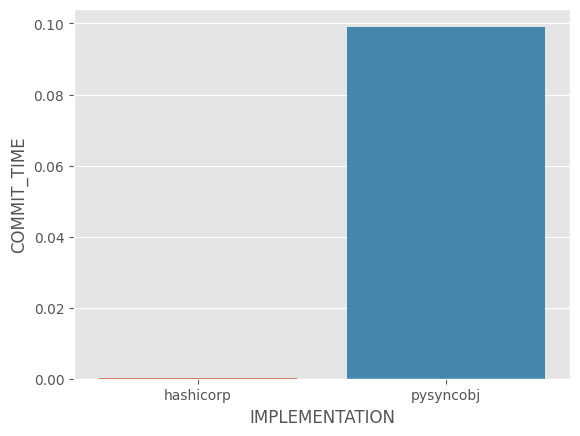

In [100]:
# It's not even close
ax = sns.barplot(REAL_DF, x='IMPLEMENTATION', y='COMMIT_TIME', hue='IMPLEMENTATION')

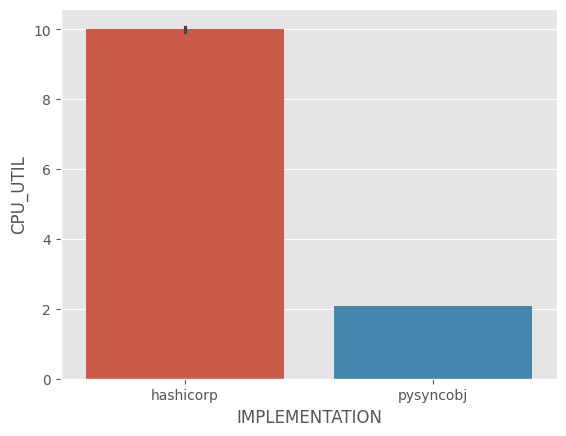

In [101]:
# It's not even close
ax = sns.barplot(REAL_DF, x='IMPLEMENTATION', y='CPU_UTIL', hue='IMPLEMENTATION')

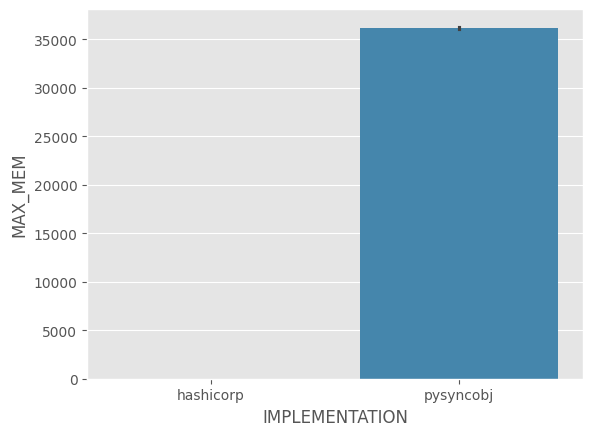

In [102]:
# It's not even close
ax = sns.barplot(REAL_DF, x='IMPLEMENTATION', y='MAX_MEM', hue='IMPLEMENTATION')

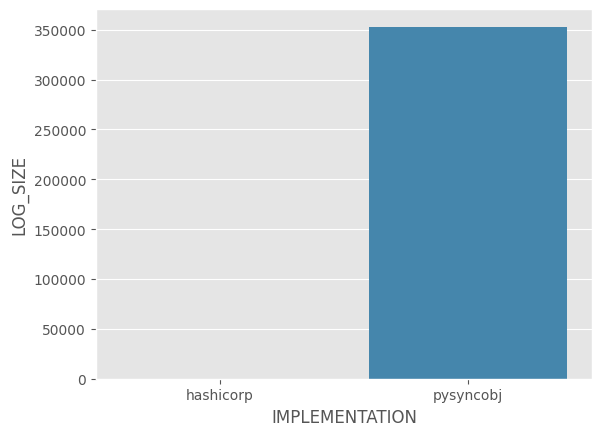

In [103]:
# It's not even close
ax = sns.barplot(REAL_DF, x='IMPLEMENTATION', y='LOG_SIZE', hue='IMPLEMENTATION')